In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = "/content/drive/MyDrive/media prediction and its cost.csv"
df_raw = pd.read_csv(file_path)

In [6]:
num_cols, cate_cols, pre_dum_cols = [], [], []
for c in df_raw.columns:
    uni_len = len(set(df_raw[c]))
    dtype = df_raw[c].dtypes

    if dtype == object:
        cate_cols.append(c)
    else: # dtype == float
        if uni_len == 2:
            pre_dum_cols.append(c)
        elif uni_len < 10:
            num_cols.append(c)
            print("Number of unique values: %d \t Datatype: %s \t Column name: %s" %(uni_len, dtype, c))
        else:
            num_cols.append(c)

Number of unique values: 6 	 Datatype: float64 	 Column name: unit_sales(in millions)
Number of unique values: 6 	 Datatype: float64 	 Column name: total_children
Number of unique values: 5 	 Datatype: float64 	 Column name: avg_cars_at home(approx)
Number of unique values: 6 	 Datatype: float64 	 Column name: num_children_at_home
Number of unique values: 5 	 Datatype: float64 	 Column name: avg_cars_at home(approx).1


In [7]:
df_raw.head()

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


# Model Development

In [8]:
y = df_raw['cost']
X = df_raw.drop(columns = ['cost'])
X = pd.get_dummies(X)

In [9]:
from sklearn.model_selection import train_test_split
X_train_final, X_test_final, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
X_test_final, X_val_final, y_test, y_val = train_test_split(X_test_final, y_test, test_size = 0.5, random_state = 0)

Since the model from TPOT yielded the lowest RMSE, we train the model based on parameters derived from TPOT as our final model.

In [11]:
from sklearn.ensemble import ExtraTreesRegressor
extratree_best = ExtraTreesRegressor(random_state = 0, bootstrap=False, max_features=0.25, min_samples_leaf=3, min_samples_split=4, n_estimators=100)
final_model_opt = extratree_best.fit(X_train_final, y_train)
y_test_pred_final = final_model_opt.predict(X_test_final)

In [11]:
from sklearn.metrics import mean_squared_error
final_model_opt_mse = mean_squared_error(y_test, y_test_pred_final, squared=False)
final_model_opt_mse

0.7806648492919666

## ELI5

In [ ]:
pip install eli5

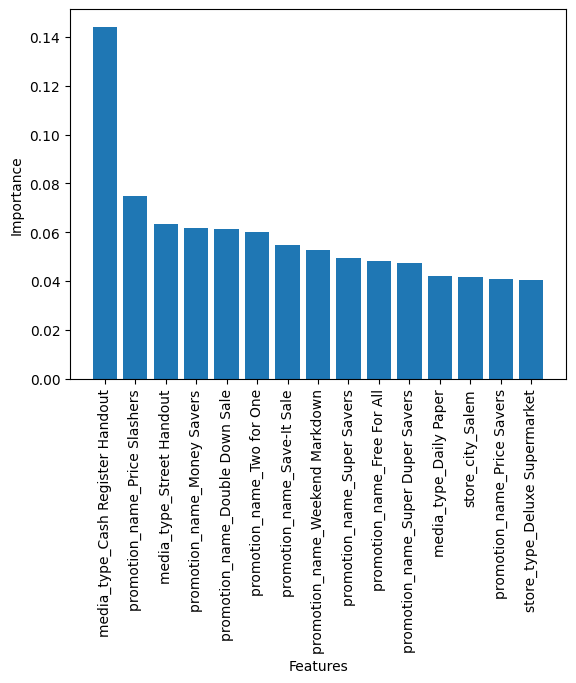

In [14]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

# Create a permutation importance object
perm = PermutationImportance(final_model_opt, random_state=0)

# Fit the object to the test set
perm.fit(X_test_final, y_test)

# Get feature importances
importances = perm.feature_importances_
features = X_test_final.columns.tolist()

# Sort features and their importances
sorted_features = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

# Select the top 15 features
top_features = sorted_features[:15]

# Unzip the features and their importances
top_feature_names, top_feature_importances = zip(*top_features)

# Plot the top 15 feature importances
plt.bar(top_feature_names, top_feature_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


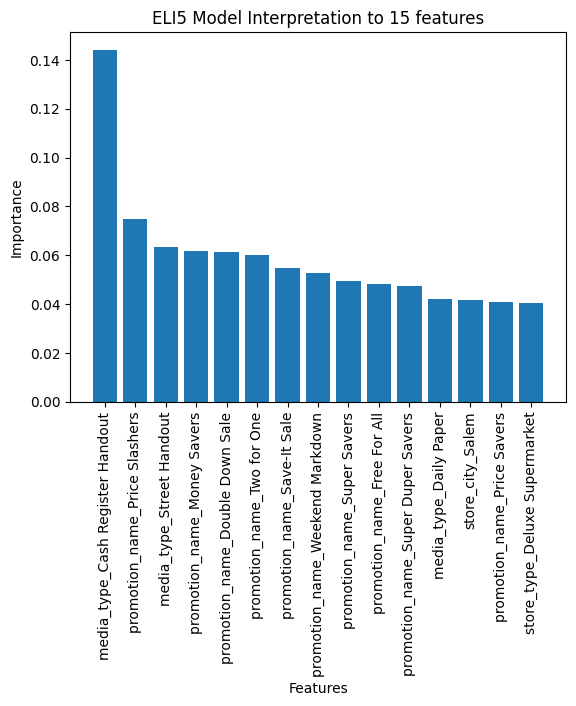

In [19]:
import matplotlib.pyplot as plt

# Plot the top 15 feature importances
bars = plt.bar(top_feature_names, top_feature_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('ELI5 Model Interpretation to 15 features')

plt.show()

# Save the plot as a JPEG file
plt.savefig("eli5_model_interpretation.jpeg", dpi=300, bbox_inches="tight")
plt.close()


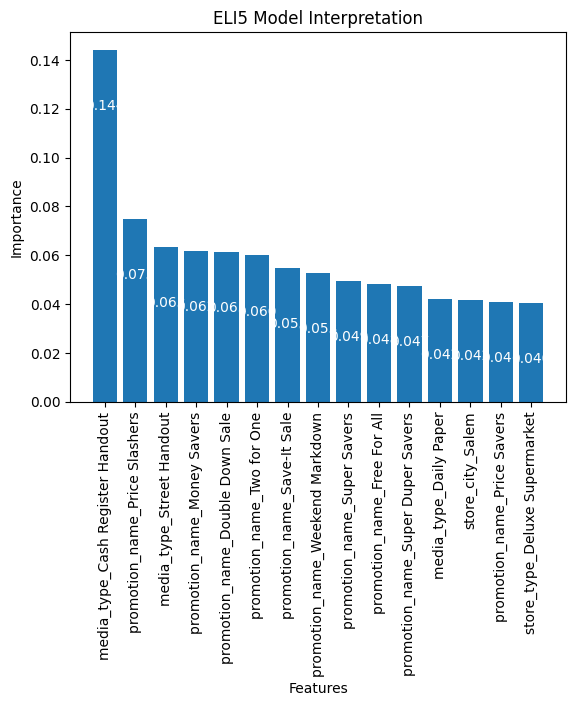

In [17]:
import matplotlib.pyplot as plt

# Plot the top 15 feature importances
bars = plt.bar(top_feature_names, top_feature_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('ELI5 Model Interpretation')

# Add the importances inside the bars
for bar, importance in zip(bars, top_feature_importances):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        bar.get_height() - 0.02,  # Y position (slightly below the top of the bar)
        f"{importance:.3f}",  # Formatted importance value
        horizontalalignment="center",
        verticalalignment="top",
        fontsize=10,
        color="white",
    )

plt.show()
